In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Model Class
class ClassicalANN(nn.Module):

    def __init__(self,in_features=5):
        super().__init__()
        self.fc1 = nn.Linear(3,50)
        self.fc2 = nn.Linear(50,120)
        self.fc7 = nn.Linear(120,4)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc7(x)

    # tanh

        return x
    

In [3]:
from torchsummary import summary

mtest = ClassicalANN().cuda()
print(summary(mtest,(1,3)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]             200
            Linear-2               [-1, 1, 120]           6,120
            Linear-3                 [-1, 1, 4]             484
Total params: 6,804
Trainable params: 6,804
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------
None


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
road_ds = pd.read_csv("E:\\Projects Continued\\VivekRoadNN\\final_data.csv")

In [6]:
from torch.utils.data import DataLoader, Dataset

class RoadDS(Dataset):
    def __init__(self,features,labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,idx):
        return self.features.iloc[idx].values,self.labels.iloc[idx]
        

In [7]:
road_ds['class_label'].value_counts()

class_label
0    142558
2     89220
3     89220
1     59994
Name: count, dtype: int64

In [54]:
# splitting the data into features and labels
X = road_ds[['gFx','gFy','gFz']]
Y = road_ds['class_label']

In [55]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)

In [56]:
trainset = RoadDS(X_train,y_train)
testset = RoadDS(X_test,y_test)

In [57]:
trainloader = DataLoader(trainset,batch_size=128,num_workers=0,shuffle=True)
testloader = DataLoader(testset,batch_size=32,shuffle=True)


In [58]:
trainset[4]


(array([0.5847851 , 0.52046764, 0.45153052]), 2)

In [59]:
y_train.value_counts()

class_label
0    99892
3    62574
2    62242
1    41986
Name: count, dtype: int64

In [60]:
X_train_tensor = torch.FloatTensor(X_train.to_numpy())
X_test_tensor = torch.FloatTensor(X_test.to_numpy())
Y_train_tensor = torch.LongTensor(y_train.to_numpy())
Y_test_tensor = torch.LongTensor(y_test.to_numpy())

X_train_tensor = X_train_tensor.cuda()
X_test_tensor = X_test_tensor.cuda()
Y_train_tensor = Y_train_tensor.cuda()
Y_test_tensor = Y_test_tensor.cuda()

In [61]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        """
        Focal Loss for classification tasks.

        Args:
            alpha (float): Weighting factor for the class balance. Default is 1.
            gamma (float): Focusing parameter to reduce the relative loss for well-classified examples. Default is 2.
            reduction (str): Specifies the reduction to apply to the output: 'none', 'mean', 'sum'. Default is 'mean'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Forward pass for Focal Loss.

        Args:
            inputs (Tensor): Predicted logits of shape (N, C) where C is the number of classes.
            targets (Tensor): Ground truth labels of shape (N) with values in [0, C-1].

        Returns:
            Tensor: Loss value.
        """
        # Convert logits to probabilities
        probs = F.softmax(inputs, dim=1)
        
        # Gather probabilities corresponding to the target labels
        target_probs = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        
        # Compute focal loss
        focal_weight = (1 - target_probs) ** self.gamma
        loss = -self.alpha * focal_weight * torch.log(target_probs)
        
        # Apply reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [62]:
lossv = FocalLoss()

In [63]:
# training model for engine b data

model = ClassicalANN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_engine_b.parameters(),lr=1e-3,weight_decay=1e-4)
losses = []

In [64]:
torch.cuda.empty_cache()
from tqdm import tqdm


In [65]:
n_epochs = 10
for epoch in tqdm(range(n_epochs)):
    for i,(inputs,labels) in tqdm(enumerate(trainloader)):
        input_torch = torch.tensor(inputs,dtype=torch.float32).view(-1,3)
        input_torch = input_torch.cuda()
        labels = torch.LongTensor(labels).cuda()

        y_pred = model(input_torch)
        loss = lossv(y_pred,labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



        losses.append(loss)


    
    
    print("epoch num {} and loss num {}".format(epoch,loss))

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\ntaru\AppData\Local\Temp\ipykernel_13088\85259532.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_torch = torch.tensor(inputs,dtype=torch.float32).view(-1,3)
2084it [00:12, 173.21it/s]
 10%|█         | 1/10 [00:12<01:48, 12.04s/it]

epoch num 0 and loss num 0.07019118219614029


2084it [00:11, 174.40it/s]
 20%|██        | 2/10 [00:23<01:35, 11.99s/it]

epoch num 1 and loss num 0.08145304024219513


2084it [00:12, 173.52it/s]
 30%|███       | 3/10 [00:36<01:23, 12.00s/it]

epoch num 2 and loss num 0.059040069580078125


2084it [00:11, 173.68it/s]
 40%|████      | 4/10 [00:48<01:12, 12.00s/it]

epoch num 3 and loss num 0.05108135938644409


2084it [00:11, 173.82it/s]
 50%|█████     | 5/10 [01:00<00:59, 12.00s/it]

epoch num 4 and loss num 0.056508567184209824


2084it [00:11, 174.38it/s]
 60%|██████    | 6/10 [01:11<00:47, 11.98s/it]

epoch num 5 and loss num 0.05798238888382912


2084it [00:11, 174.97it/s]
 70%|███████   | 7/10 [01:23<00:35, 11.96s/it]

epoch num 6 and loss num 0.059478554874658585


2084it [00:11, 174.80it/s]
 80%|████████  | 8/10 [01:35<00:23, 11.95s/it]

epoch num 7 and loss num 0.05856272950768471


2084it [00:12, 170.51it/s]
 90%|█████████ | 9/10 [01:48<00:12, 12.04s/it]

epoch num 8 and loss num 0.05774243175983429


2084it [00:12, 170.49it/s]
100%|██████████| 10/10 [02:00<00:00, 12.02s/it]

epoch num 9 and loss num 0.05982564017176628


  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

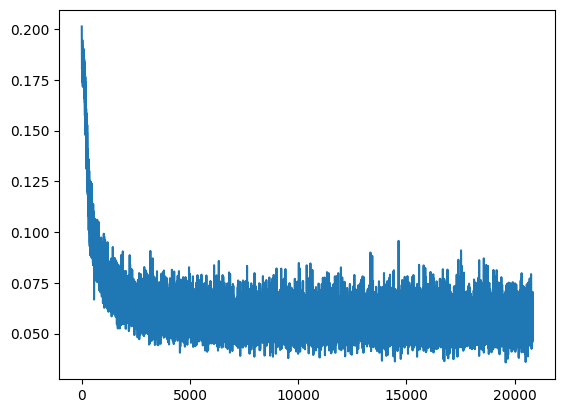

In [66]:
import matplotlib.pyplot as plt

losses = [l.item() for l in losses]
plt.plot(losses)

In [ ]:
im

In [67]:
# calculating accuracy
correct = 0
total = 0

y_preds_arr = []

with torch.no_grad():
    for i,data in enumerate(X_test_tensor):
        y_test_pred = model.forward(X_test_tensor[i])

        y_preds_arr.append(y_test_pred.argmax().item())

        if(y_test_pred.argmax().item() == Y_test_tensor[i].item()):
            correct += 1
        
        total += 1



KeyboardInterrupt: 

In [68]:
correct/total

0.6914830867078706

In [69]:
from sklearn.metrics import classification_report

print(classification_report(Y_test_tensor.cpu().numpy()[:i],y_preds_arr[:i],zero_division=True))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14455
           1       0.67      0.79      0.72      6195
           2       0.47      0.08      0.14      9248
           3       0.45      0.76      0.57      9095

    accuracy                           0.69     38993
   macro avg       0.64      0.66      0.60     38993
weighted avg       0.68      0.69      0.64     38993



In [70]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test_tensor.cpu().numpy()[:i],y_preds_arr)

array([[14453,     0,     2,     0],
       [   29,  4878,    30,  1258],
       [  175,  1175,   733,  7165],
       [  159,  1253,   784,  6899]], dtype=int64)